This assignment builds upon the skills you practiced in the in-class lab.

You will build your RAG system for a new business scenario.

**Submission Guidelines:**
Your final submission should contain the following items:
1. Your completed .ipynb file (this file).
2. The analysis report in PDF or DOCX format.

**Important**: For code cells, you will only need to modify the code within the

`# ------------ Edit Area Start/End -----------------` blocks.


# **Preparation**

## **1 Install Python libraries**

First, we need to install the necessary Python libraries by running the following code block.

In [3]:
!pip install -U langchain langchain-openai langchain-azure-ai langchain-community langchain-text-splitters faiss-cpu pypdf python-docx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323

## **2 Setup Azure API**

We set up the connection details for the Azure AI service. In this lab, we use `gpt-4.1-nano` provided Microsoft Azure.

In [1]:
# ------------ Edit AREA Start---------------------------------
# Replace `"YOUR_AZURE_API_KEY"` with your actual subscription key.
# Replace `"CLASS"` with your class num.
AZURE_API_KEY = "64cf10ca250643219150e9a329988dca"
CLASS = "MIS372T"
# ------------ Edit AREA End----------------------------------

In [2]:
from langchain.chat_models import init_chat_model
from langchain_openai import AzureOpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from typing import List
import os
from pathlib import Path
from typing import Tuple

# APIM bases
AZURE_INFERENCE_BASE = f"https://aistudio-apim-ai-gateway02.azure-api.net/{CLASS}/v1/models"  # chat base
AZURE_OPENAI_BASE    = f"https://aistudio-apim-ai-gateway02.azure-api.net/{CLASS}/v1"         # embeddings base

# Keys (how APIM validates can vary by your policy)
# - For Azure AI Inference chat, `credential` is the API key forwarded to your backend (or validated at APIM).
# - For Azure OpenAI embeddings, `openai_api_key` is forwarded to your backend.
# - If APIM requires an additional subscription header, set APIM_SUBSCRIPTION_KEY.
AZURE_INFERENCE_API_KEY = os.getenv("AZURE_INFERENCE_API_KEY", "LEAVE_ALONE")
AZURE_OPENAI_API_KEY    = os.getenv("AZURE_OPENAI_API_KEY", "LEAVE_ALONE")
APIM_SUBSCRIPTION_KEY   = AZURE_API_KEY

# Versions / names
CHAT_API_VERSION = "2024-05-01-preview"
EMBED_API_VERSION = "2023-05-15"
CHAT_MODEL_NAME = "gpt-4.1-nano"         # The model name you exposed via APIM for chat
EMBED_DEPLOYMENT = "text-embedding-3-small"  # The Azure OpenAI embedding deployment name behind APIM

# Headers for APIM (optional, depending on your policy). We'll include both chat and embeddings usage.
APIM_HEADERS = {"Ocp-Apim-Subscription-Key": APIM_SUBSCRIPTION_KEY} if APIM_SUBSCRIPTION_KEY else {}

## Define the load_text_from_file function to load text from files, supporting TXT, PDF, DOCX
def load_text_from_file(path: str) -> str:
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {path}")
    suffix = p.suffix.lower()

    if suffix in [".txt", ".md"]:
        return p.read_text(encoding="utf-8", errors="ignore")

    if suffix == ".pdf":
        try:
            from pypdf import PdfReader
        except Exception:
            raise RuntimeError("pypdf is required for PDFs. Install via `pip install pypdf`.")
        text_parts = []
        reader = PdfReader(str(p))
        for page in reader.pages:
            t = page.extract_text() or ""
            text_parts.append(t)
        return "\n".join(text_parts)

    if suffix in [".docx", ".doc"]:
        try:
            import docx
        except Exception:
            raise RuntimeError("python-docx is required for DOCX. Install via `pip install python-docx`.")
        doc = docx.Document(str(p))
        return "\n".join([para.text for para in doc.paragraphs])

    raise ValueError(f"Unsupported file type: {suffix}. Use .txt, .md, .pdf, or .docx")


# **Build an E-Commerce Customer Service RAG System**

Imagine you are a **Customer Service Agent** for **5** e-commerce platforms-- **Walmart, Target, Best Buy, Nike, Macy's**-- tasked with assisting users in understanding various platform policies related to returns, exchanges, discounts, shipping, and more. In order to fully consider the time range of user issues, you must also collect **policy updates from these platforms over the last 5 years**.

Your goal is to design a system that can retrieve specific policy information from the knowledge base of each platform and use a language model to generate accurate, user-friendly answers to complex customer queries.

This assignment requires you to go through the essential steps to create a RAG system:

1. **Knowledge Base Construction**:
Collect, organize, and preprocess the policy documents from 5 different e-commerce platforms: **Walmart, Target, Best Buy, Nike, Macy's** These documents should include policies on:

- Returns and refunds (e.g., eligibility, timelines, conditions)
- Exchange processes
- Discount rules and promotions
- Shipping options, costs, and timelines
- Price match
- Policy updates over the past 5 years.

Ensure the knowledge base is well-structured for efficient retrieval.
2. **Indexing:**
Prepare and index the knowledge base for fast and effective retrieval. Use document segmentation techniques to break down policy documents into smaller, meaningful chunks that correspond to specific topics.

3. **Retrieval:**
Implement a retriever that searches for the most relevant sections of the indexed knowledge base based on a customer's query.


4. **Generation:**
Use a language model to synthesize clear and concise answers from the retrieved policy information. The answers should be:

Accurate and directly aligned with the original policy text
Easy to understand for a wide range of users
Polite and professional in tone

4. **Evaluation:**
The evaluation will involve answering a set of test questions for each platform to assess the system’s accuracy and efficiency. Example evaluation questions include:

- Returns: "Can I return a product after 30 days if it is unused?"
- Exchanges: "What is the process for exchanging a damaged item on Platform D?"
- Discounts: "Are seasonal discounts available for Platform E?"
- Shipping: "How long does expedited shipping take on Platform C?"
- Price match: "Does Platform A price match Platform B?"
- Policy Updates: "Compare the return window available to a high-spending customer at Best Buy in 2021 versus 2024."

## **Step 1: Indexing**

In Retrieval Augmented Generation (RAG), indexing organizes and structures your data for efficient search and retrieval, similar to a book index that helps you quickly locate information without reading everything.


### **1.1 Collect Knowledge**

Your RAG system’s ability to generate accurate, contextually relevant answers will depend heavily on the quality of the knowledge you have collected. Focus on gathering detailed, comprehensive, and well-structured information to ensure your system performs effectively.

1.  **Collect Product Information:** Gather high-quality, relevant policy information about 5 different e-commerce platforms -- **Walmart, Target, Best Buy, Nike, Macy's** -- to build your knowledge base.

2.  **Upload into Google Colab:** Once you have collected your information, upload it into Google Colab in a structured format (.TXT file is highly recommended). In the **left sidebar** of Colab, you can select the **files** icon. Then you can upload your organized knowledge base .TXT file to the Colab. The process is shown in the following image.

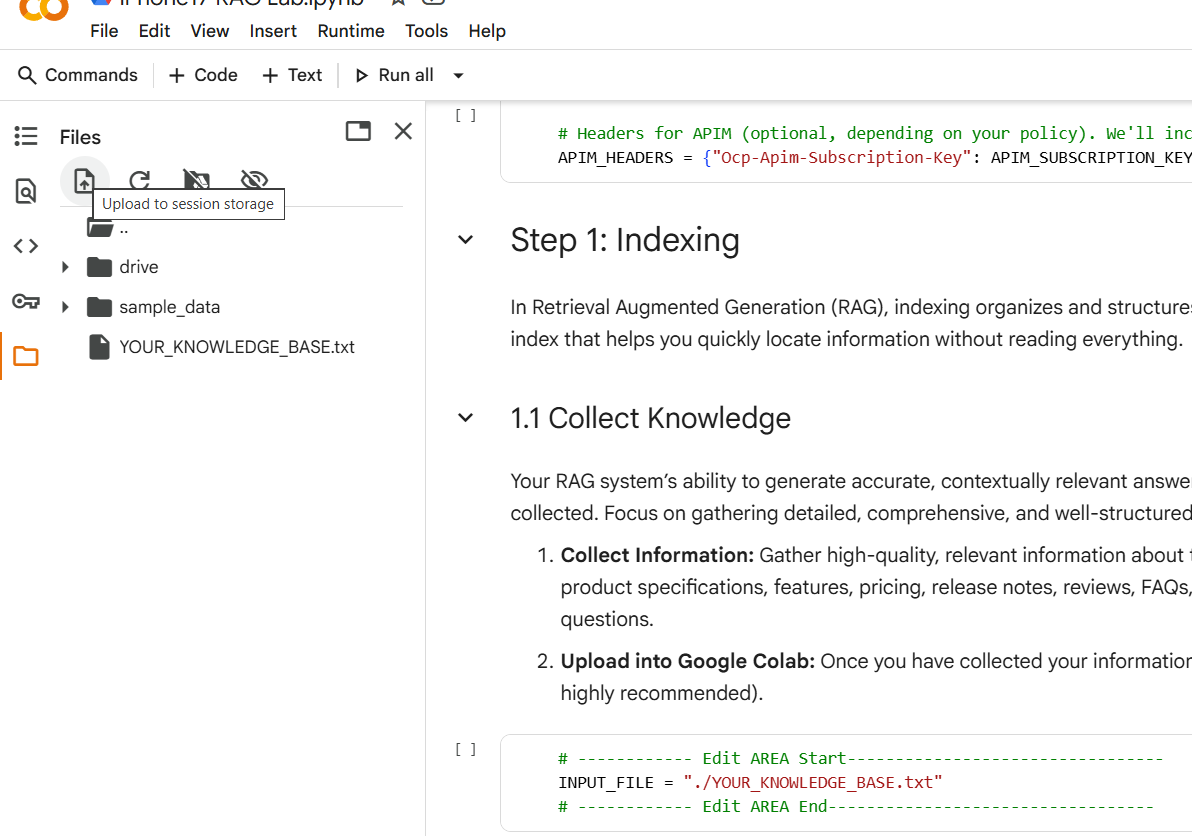

In [3]:
# ------------ Edit AREA Start---------------------------------
# 1. Collect your own knowledge base.
# 2. Organize it into a .TXT file.
# 3. Upload the .TXT file into this Colab.

INPUT_FILE = "Stores_Data.txt"
# ------------ Edit AREA End----------------------------------

### **1.2 Ingest & Clean**

This step involves gathering your raw data (ingestion) and processing it to make it suitable for the next steps in the RAG pipeline (cleaning). This process ensures that you have clean, relevant text data to work with for chunking and embedding.

In [4]:
# ------------ Edit AREA Start---------------------------------
# Implement raw_knowledge_base
# You should use load_text_from_file function to load text for your knowledge base .TXT file
# The variable should be INPUT_FILE

raw_knowledge_base = load_text_from_file(INPUT_FILE)
print(f"Loaded {len(raw_knowledge_base)} characters from {INPUT_FILE}")

# ------------ Edit AREA End---------------------------------


Loaded 5756 characters from Stores_Data.txt


### **1.3 Chunk**

The following code demonstrates the chunking step, which breaks large text documents into smaller, manageable pieces. This process is **crucial** for RAG because large documents can be too long for the language model to process effectively.

In [8]:
# We'll use tools from LangChain to do this easily.
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# First, we need to convert our string into a LangChain 'Document' object.
# This is a standard format that LangChain tools know how to work with.

docs = [Document(page_content=raw_knowledge_base)]

# ------------ Edit AREA Start---------------------------------
# You may research on your own to see how CHUNK_SIZE and CHUNK_OVERLAP effect RAG results.
CHUNK_SIZE=500
CHUNK_OVERLAP=50
# ------------ Edit AREA End---------------------------------

# ------------ Edit AREA Start---------------------------------
# Implement text_splitter and split_documents HERE
# You should use RecursiveCharacterTextSplitter and text_splitter.split_documents functions
# The variables of text_splitter are chunk_size and chunk_overlap
# The variable of split_documents is docs
text_splitter = RecursiveCharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)
split_documents = text_splitter.split_documents(docs)


print(f"Step 1.3: The knowledge base was split into {len(split_documents)} smaller Chunks. 📄 -> 📄📄📄")
print(split_documents[0].page_content)

# ------------ Edit AREA End---------------------------------

Step 1.3: The knowledge base was split into 16 smaller Chunks. 📄 -> 📄📄📄
--- Walmart ---
Returns and Refunds:
- The standard return period for most items purchased at Walmart is 90 days after purchase or receipt[web:1][web:2][web:5][web:4][web:21].
- Consumer electronics must be returned within 30 days; major appliances within 2 days[web:2][web:27].
- Most other products have the 90-day window; some (drones, wireless, prepaid cards, custom) are excluded[web:5][web:27][web:34].


### **1.4 Embed**

This step involves converting the text chunks into numerical representations called embeddings.

In [9]:
# Let's import the necessary tools.
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

# ------------ Edit AREA Start---------------------------------
# Implement embeddings
# You should use AzureOpenAIEmbeddings function
# The variables are azure_endpoint, azure_deployment, api_version, openai_api_key, and default_headers

embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=AZURE_OPENAI_BASE,
    azure_deployment=EMBED_DEPLOYMENT,
    api_version=EMBED_API_VERSION,
    openai_api_key=AZURE_OPENAI_API_KEY,
    default_headers=APIM_HEADERS or None,
)

print("Step 1.4: Embedding has been created. All text chunks are now represented as numbers. 🔢")

# ------------ Edit AREA End---------------------------------

Step 1.4: Embedding has been created. All text chunks are now represented as numbers. 🔢


### **1.5 Store**

This step involves loading the embeddings and their associated text chunks into a specialized database designed for efficient searching, often called a **vector database**.

In [10]:
# ------------ Edit AREA Start---------------------------------
# Implement vector_store
# Use FAISS.from_documents function
# The variables are split_documents and embeddings
from langchain_community.vectorstores import FAISS
vector_store = FAISS.from_documents(split_documents, embeddings)

# Output for reference (chunked text)
CHUNK_TEXT_OUT = "Stores_Data.txt"
# Save chunked text + vectors:
with open(CHUNK_TEXT_OUT, "w", encoding="utf-8") as f:
    for i, d in enumerate(split_documents):
        f.write(f"===== CHUNK {i} =====\n")
        f.write(d.page_content)
        f.write("\n\n")

        # Embed the chunk manually to expose vector
        vec = embeddings.embed_query(d.page_content)

        # Write vector
        f.write("VECTOR:\n")
        f.write(str([vec]))
        f.write("\n\n")

print("Step 1.5: Vector store has been created. All text chunks are now stored. 🔢")

# ------------ Edit AREA End---------------------------------

Step 1.5: Vector store has been created. All text chunks are now stored. 🔢


## **Step 2: Retrieval**

The Retrieval step finds the most relevant information in the vector database to answer a user's query. The process is as follows:

1.  **Encode the user query** into a vector using the same embedding model that was used on the documents.
2.  **Compute similarity scores** (e.g., cosine similarity) between the query vector and all the document chunk vectors in the database.
3.  **Retrieve the "Top-K"** (a predefined number) of the most similar chunks to use as the context for the final answer generation.


In [11]:
# ------------ Edit AREA Start---------------------------------
# Implement retriever
# You should use vector_store.as_retriever function
# You can modify the parameter top-K to determine how many revelant chunks are retrieved.
# You can play with the TOP-K parameter and see how it affects RAG results.
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

print("Step 2: The retriever is ready to find relevant information. 🔍")

# ------------ Edit AREA End---------------------------------


Step 2: The retriever is ready to find relevant information. 🔍


In [12]:
# ------------ Edit AREA Start---------------------------------
# You can design a revelant test question to test if your retriever works well.
retriever_test_question="What is Walmart's standard return period for most items purchased?"

retrieved_docs = retriever.invoke(retriever_test_question)
# ------------ Edit AREA End---------------------------------

# Print the retrieval results
print("\n--- Retriever Test ---")
print(f"Found {len(retrieved_docs)} relevant documents for the test query.")
print(f"Most relevant document content: \n...{retrieved_docs[0].page_content}...")
print("--- End Test ---\n")


--- Retriever Test ---
Found 5 relevant documents for the test query.
Most relevant document content: 
...--- Walmart ---
Returns and Refunds:
- The standard return period for most items purchased at Walmart is 90 days after purchase or receipt[web:1][web:2][web:5][web:4][web:21].
- Consumer electronics must be returned within 30 days; major appliances within 2 days[web:2][web:27].
- Most other products have the 90-day window; some (drones, wireless, prepaid cards, custom) are excluded[web:5][web:27][web:34]....
--- End Test ---



## **Step 3: Generation**

The final step, Generation, uses a language model to synthesize a coherent answer from the user's query and the retrieved information.

1.  **Build the Prompt:** The user's original query is combined with the retrieved text chunks to create a comprehensive prompt for the language model.

2.  **Construct RAG Pipeline:** We assemble the vector store, retriever, prompt and LLMs into a workflow.

3.  **Answer Generation:** The language model generates a final answer that is grounded in the retrieved documents. This "augmented" approach reduces the risk of factual errors or "hallucinations," leading to more accurate, contextually relevant responses.

### **3.1 Build the Prompt**

Building the prompt is the step where the user's query and the retrieved documents are combined into a single, clear instruction for the language model. In Lecture 5 (Prompt Engineering), we introduced a comprehensive prompt template:

```
* ROLE: <optional persona/audience>
* INSTRUCTION: <what to do>
* CONTEXT: <facts/tables/passage to use>
* INPUT: <the specific text/question>
* OUTPUT FORMAT: <exact schema or example of final output>
* CONSTRAINTS: <length, style, units, banned words>
* CHECKS:
    - If missing info → reply INSUFFICIENT.
    - Validate format before emitting.
```

In [16]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser


# ------------ Edit AREA Start---------------------------------
# Create your own Prompt for Custom Service Assistant Tasks
PROMPT_TEMPLATE ="""
ROLE:
You are a knowledgeable and helpful Customer Service Assistant specializing in answering questions about policies from Walmart, Target, Best Buy, Nike, and Macy’s.

INSTRUCTION:
Use ONLY the following retrieved context to answer the customer's question accurately and clearly.

RESPONSE PROTOCOL:
If the necessary information is missing from the context, politely respond that you do not have that information.

CONTEXT:
{context}

QUESTION:
{question}
"""

PROMPT = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
# ------------ Edit AREA End---------------------------------

llm = init_chat_model(
    model=CHAT_MODEL_NAME,
    model_provider="azure_ai",
    endpoint=AZURE_INFERENCE_BASE,
    credential=AZURE_INFERENCE_API_KEY,
    api_version=CHAT_API_VERSION,
    client_kwargs={"headers": APIM_HEADERS} if APIM_HEADERS else None,
)

### **3.2 Construct RAG Pipeline**

The RAG pipeline connects all the components—vector store, retriever, prompt, and LLM—into a unified workflow that efficiently processes queries and generates grounded answers.

A typical RAG pipeline operates as follows:

1. **Query Input:** The user's question is sent to the retriever.
2. **Retrieve Context:** The retriever fetches relevant documents or text chunks from the vector store.
3. **Format Prompt:** The retrieved context, along with the user’s question, is filled into a structured prompt template.
4. **Generate Answer:** The prompt is passed to the LLM, which synthesizes a response based on the provided context.
5. **Output Parsing:** The generated text is optionally cleaned or formatted for delivery.

In [17]:
# This function helps format the retrieved documents into a single block of text.
def format_docs(docs):
    return "\n\n".join(d.page_content for d in docs)


# Here's how our chain will work:
# 1. The user's question comes in.
# 2. The `retriever` gets the question and finds the relevant context.
# 3. The `prompt` template gets the context and the original question.
# 4. The `llm` gets the filled-in prompt and generates the answer.
# 5. The `StrOutputParser` cleans up the LLM's output into a simple string.


# ------------ Edit AREA Start---------------------------------
# Implement rag_chain
rag_chain = (
    # minor: RunnablePassthrough is an identity block; returns whatever you give it unchanged
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | PROMPT # prompt template
    | llm # refer to the llm we will use
    | StrOutputParser() # Output format/clean
)

print("Step 3.2: The RAG pipeline has been created. We're ready to answer questions! ✅")
# ------------ Edit AREA End---------------------------------

Step 3.2: The RAG pipeline has been created. We're ready to answer questions! ✅


### **3.3 Generation**

Now that we have the prompt, which includes the user's query and the relevant context retrieved from our documents, we can use a language model to generate an answer.

Try to ask revelant questions that can be answered using the knowledge base you provided.

In [18]:
# ------------ Edit AREA Start---------------------------------
# Design test questions to test your rag_chain

test_question="What is Walmart's standard return period for most items purchased?"
# ------------ Edit AREA End---------------------------------

response = rag_chain.invoke(test_question)
print(response)

Walmart's standard return period for most items purchased is 90 days after purchase or receipt.


#### **Generation without RAG**

You can use following code cell to generate response without RAG. Compare two responses and see how greatly RAG improves LLMs' outputs.

In [19]:
# 1. Create Non-RAG prompt template
NON_RAG_PROMPT_TEMPLATE = """
QUESTION:
{question}

Please answer the user's question based on your general knowledge.
"""

NON_RAG_PROMPT = ChatPromptTemplate.from_template(NON_RAG_PROMPT_TEMPLATE)

# 2. Chain them together.
non_rag_chain = NON_RAG_PROMPT | llm | StrOutputParser()

# 3. Generate answer to your test question without RAG
non_rag_response = non_rag_chain.invoke(test_question)
print(non_rag_response)



Walmart's standard return period for most items purchased is typically 90 days from the date of purchase.


## **Evaluate Your RAG system**

Now you succesfully built your own RAG system. You need to act as a Costum Service Assistant to answer 12 questions below about your policy.

**Note:** You may update your existing knowledge base .TXT to supplement product information. Please remember to **re-run the cell you modified and all subsequent cells** to ensure your Colab notebook reflects the changes correctly.

In [20]:
import json
# Five Evaluation Questions
evaluate_questions=[
    "What is the standard return period for most items purchased at Walmart?", # Returns and refunds
    "What is the return shipping fee for a non-Star Rewards member returning an item by mail to Macy's?", # Shipping
    "What is the minimum purchase amount to get free shipping on Target.com without a Target Circle Card?", # Shipping
    "What types of damage does the Walmart 'Accident Plan' cover for a laptop?", # Exchange
    "Does Best Buy price match Amazon.com?", # Price match
    "Which retailer has a more customer-friendly price match policy regarding competitors: Walmart or Best Buy?", # Price match
    "At Walmart, what is the difference in the return window between a consumer electronic device and a major appliance?", # Returns and refunds
    "Can I get a price adjustment at Macy's if I used a 20% off coupon on my original purchase?", # Discount
    "Can I return a Target Owned Brand jacket after 18 months?", # Returns and refunds
    "Can I, as a new Best Buy customer in 2025, earn Elite Plus status by spending over $3,500?", # Policy updates
    "I want to price match a TV I see on Amazon at a Target store in September 2025. Is this possible?", # Policy updates
    "What key benefits were added to the Walmart+ program between its initial launch in 2020 and the end of 2023?" # Policy updates
]

results=[]

# Generation
for question in evaluate_questions:
  response = rag_chain.invoke(question)
  results.append({
        "question": question,
        "response": response
    })

print(json.dumps(results, indent=2, ensure_ascii=False))

[
  {
    "question": "What is the standard return period for most items purchased at Walmart?",
    "response": "The standard return period for most items purchased at Walmart is 90 days after purchase or receipt."
  },
  {
    "question": "What is the return shipping fee for a non-Star Rewards member returning an item by mail to Macy's?",
    "response": "The return shipping fee for a non-Star Rewards member returning an item by mail to Macy's is $9.99 plus tax."
  },
  {
    "question": "What is the minimum purchase amount to get free shipping on Target.com without a Target Circle Card?",
    "response": "The minimum purchase amount to get free shipping on Target.com without a Target Circle Card is $35."
  },
  {
    "question": "What types of damage does the Walmart 'Accident Plan' cover for a laptop?",
    "response": "The Walmart Accident Plan for laptops covers drops, spills, cracked screens, screen failure, battery failure, and liquid damage. It does not cover intentional damag

### **Submission and Grading**

**Important:** After you submit this `.ipynb` file with your answers, TA will rerun your code from scratch and test your RAG system on an additional **8 additional Hold-Out evaluation questions** to verify its performance and robustness. Please be assured that these 8 questions will not go beyond the scope of the requirements mentioned above (i.e., they will only pertain to the 5 specified retailers and their policies). Good luck!

# **Report**

INSTRUCTION: After finishing all the steps above, answer the following questions:

1. **Impact of the Retriever's top-k Parameter:** Investigate and discuss how the top-k parameter of your retriever affects the overall performance of your RAG system. Experiment on your **test question** with different values for top-k (e.g., 1, 3, 5) and explain how each value influenced the context retrieved and the quality of the final generated answers.

2. **Comparative Analysis with Google's AI Overview:** Compare the **accuracy** of your custom RAG system with the RAG service provided by Google Search's **AI Overview**. Pose at least 3-5 of the same customer questions to Google and analyze the results. Discuss the strengths and weaknesses of your system compared to Google's, considering potential reasons for any differences in accuracy or relevance.

3. **Pros and Cons of the RAG Approach:** Based on your experience in this project, analyze the general advantages (pros) and disadvantages (cons) of using a Retrieval-Augmented Generation (RAG) architecture.

Image: Illustration of Google Search's **AI Overview**

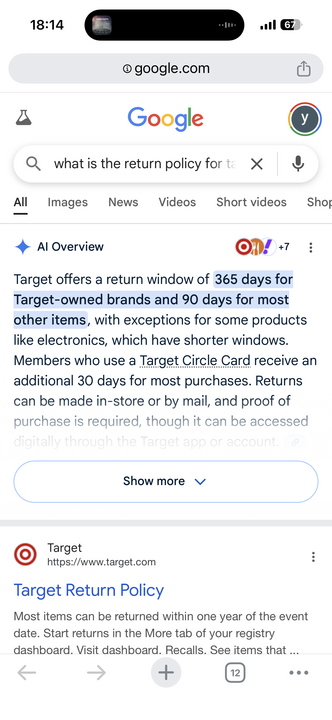